In [1]:
from utils import wandb_to_beaker_result, beaker_to_xarray
import xarray as xr
import matplotlib.pyplot as plt
import yaml
from scipy.signal import butter, lfilter
xr.set_options(keep_attrs=True)
plt.rcParams['figure.dpi'] = 300

In [2]:
with open("wandb_ids.yaml", "r") as f:
    wandb_ids = yaml.safe_load(f)
wandb_id = wandb_ids['era5-co2-10yr-RS2-IC0-ni']
beaker_dataset_id = wandb_to_beaker_result("ace", wandb_id)
variables = ['PRATEsfc']

URL_SHiELD = "gs://vcm-ml-intermediate/2024-07-24-vertically-resolved-c96-1deg-shield-amip-ensemble-dataset/ic_0001.zarr"

In [3]:
beaker_dataset_id

'01J97MNMEB9NTZDBTM40MYYXJP'

### Load data and take daily means

In [4]:
ds_pred = beaker_to_xarray(beaker_dataset_id, "autoregressive_predictions.nc")
ds_pred = ds_pred.isel(sample=0)
ds_pred = ds_pred[variables]
ds_pred['time'] = ds_pred['valid_time']
ds_pred = ds_pred.resample(time='1D').mean()

#ds_pred = ds_pred.sel(time=slice('2003', '2008'))

ds_target = beaker_to_xarray(beaker_dataset_id, "autoregressive_target.nc")
ds_target = ds_target.isel(sample=0)
ds_target = ds_target[variables]
ds_target['time'] = ds_target['valid_time']
ds_target = ds_target.resample(time='1D').mean()
#ds_target = ds_target.sel(time=slice('2003', '2008'))

Output()

Output()

In [5]:
ds_shield = xr.open_zarr(URL_SHiELD)
ds_shield = ds_shield[variables]
ds_shield = ds_shield.sel(time=slice('2000', '2011'))
ds_shield = ds_shield.resample(time='1D').mean()
ds_shield = ds_shield.sel(time=ds_target.time)
ds_shield = ds_shield.rename(grid_xt='lon', grid_yt='lat')
ds_shield['lon'] = ds_target.lon
ds_shield['lat'] = ds_target.lat

In [6]:
da = xr.concat(
    [
        (86400*ds_target.PRATEsfc).assign_coords(source="a) ERA5"),
        (86400*ds_pred.PRATEsfc).assign_coords(source="b) ACE2-ERA5"),
    ],
    dim="source",
    compat="override",
    coords="minimal",
)
del ds_pred, ds_target
da = xr.concat(
    [
        da, (86400*ds_shield.PRATEsfc).assign_coords(source="c) SHiELD")
    ], 
    dim="source",
    compat="override",
    coords="minimal",
)
del ds_shield
da.attrs['units'] = 'mm/day'

In [7]:
tropical_precip = da.sel(lat=slice(-10, 10)).mean('lat')
tropical_precip.attrs['long_name'] = 'Daily mean precipitation rate averaged from 10°S to 10°N'
del da

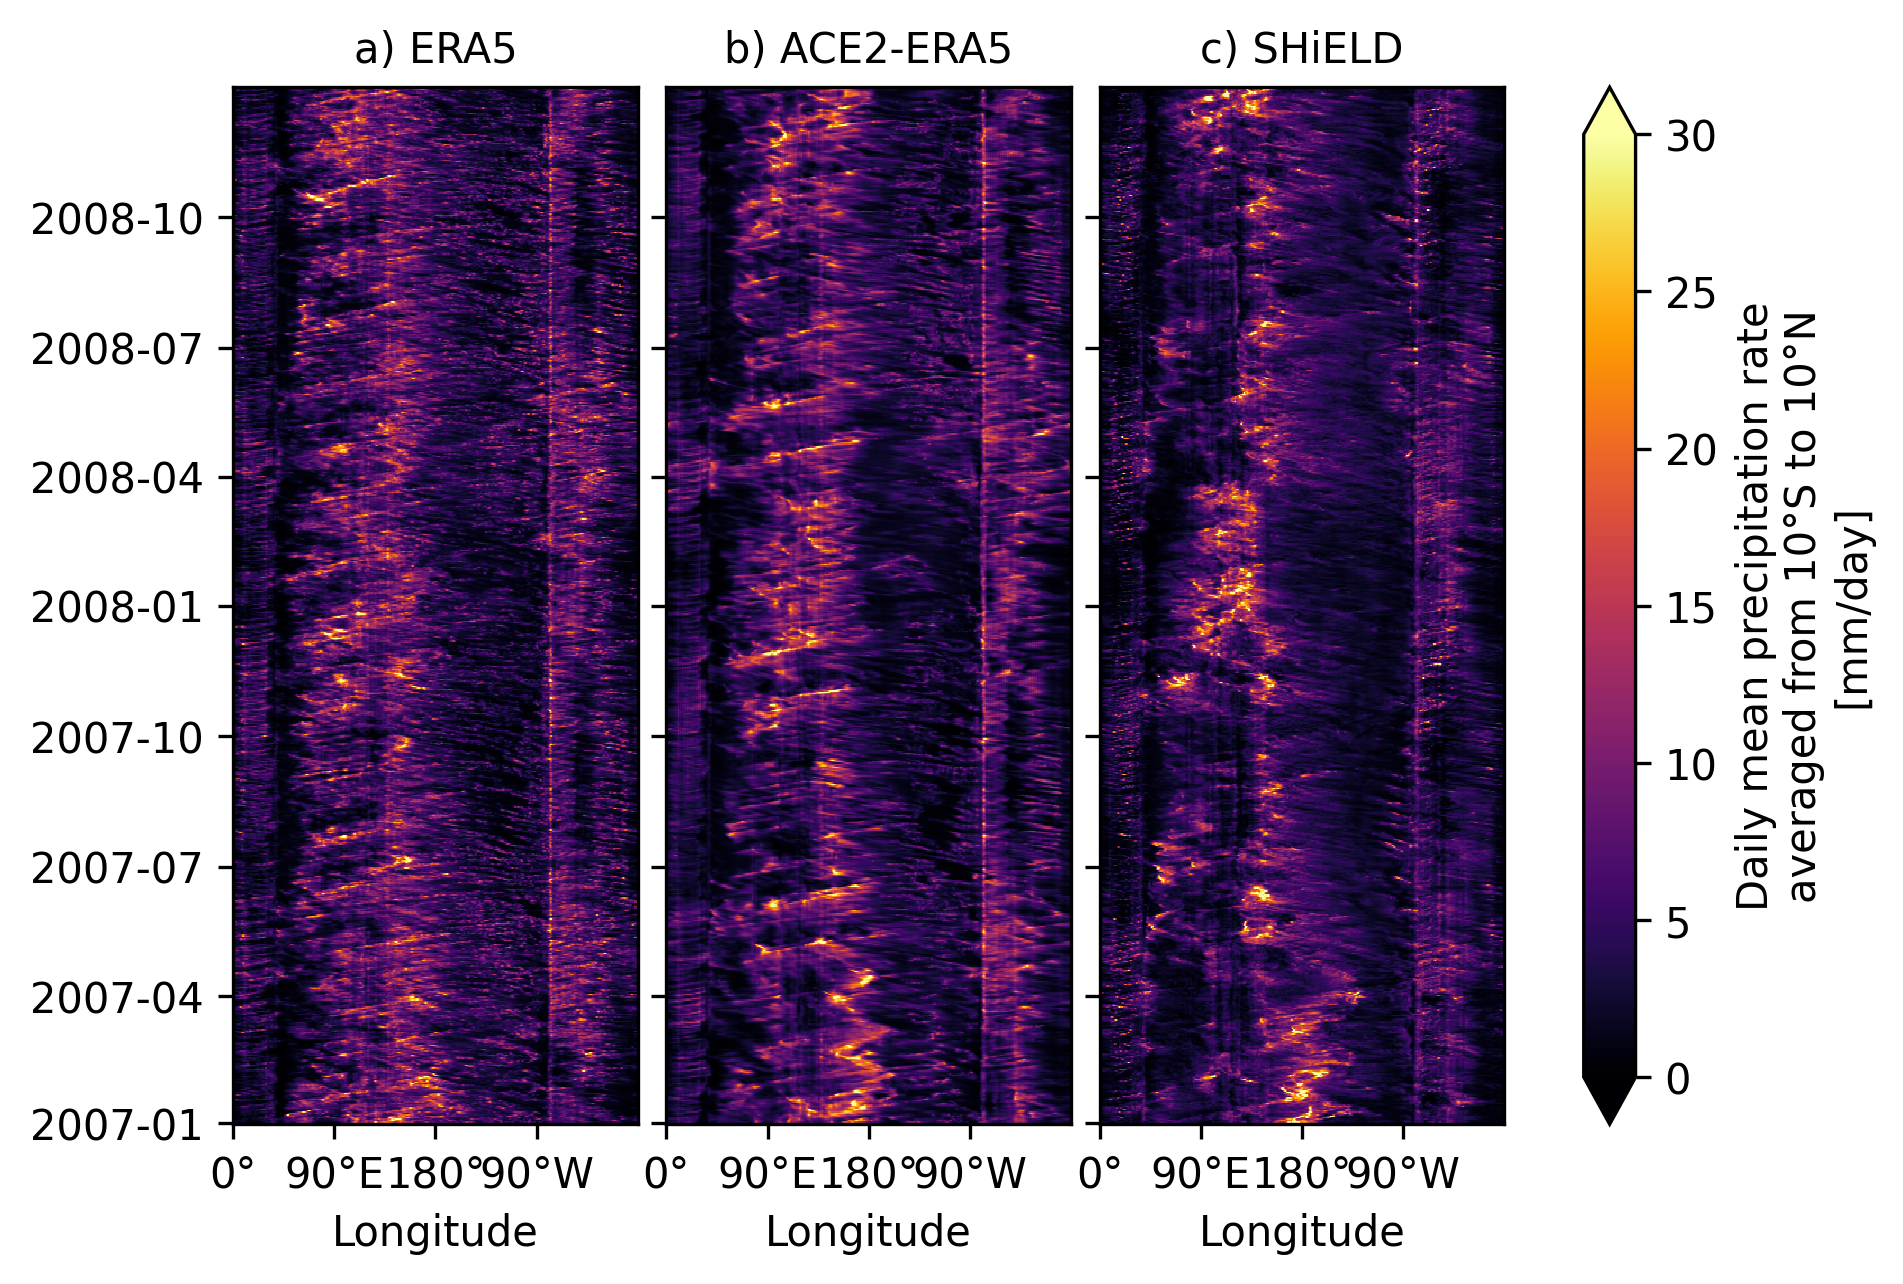

In [8]:
fg_hov = tropical_precip.sel(time=slice('2007', '2008')).plot(y='time', col='source', vmin=0, vmax=30, cmap='inferno')
fg_hov.fig.set_size_inches((6, 5))
fg_hov.set_titles(template='{value}')
fg_hov.set_ylabels('')
fg_hov.set_xlabels('Longitude')
for ax in fg_hov.axs.flat:
    ax.set_xticks([0, 90, 180, 270], labels=['0°', '90°E', '180°', '90°W'])
fg_hov.fig.savefig('figures/era5_daily_tropical_precip.png', bbox_inches='tight', transparent=True, dpi=300)


In [9]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=1)
    return y

In [10]:
low_period = 20  # in days
high_period = 100
filtered = tropical_precip.copy(deep=True)
filtered.values = butter_bandpass_filter(tropical_precip, 1/high_period, 1/low_period, 1.0)
filtered.attrs['long_name'] = f"{low_period}-{high_period} day bandpass filtered precipitation rate averaged from 10°S to 10°N"

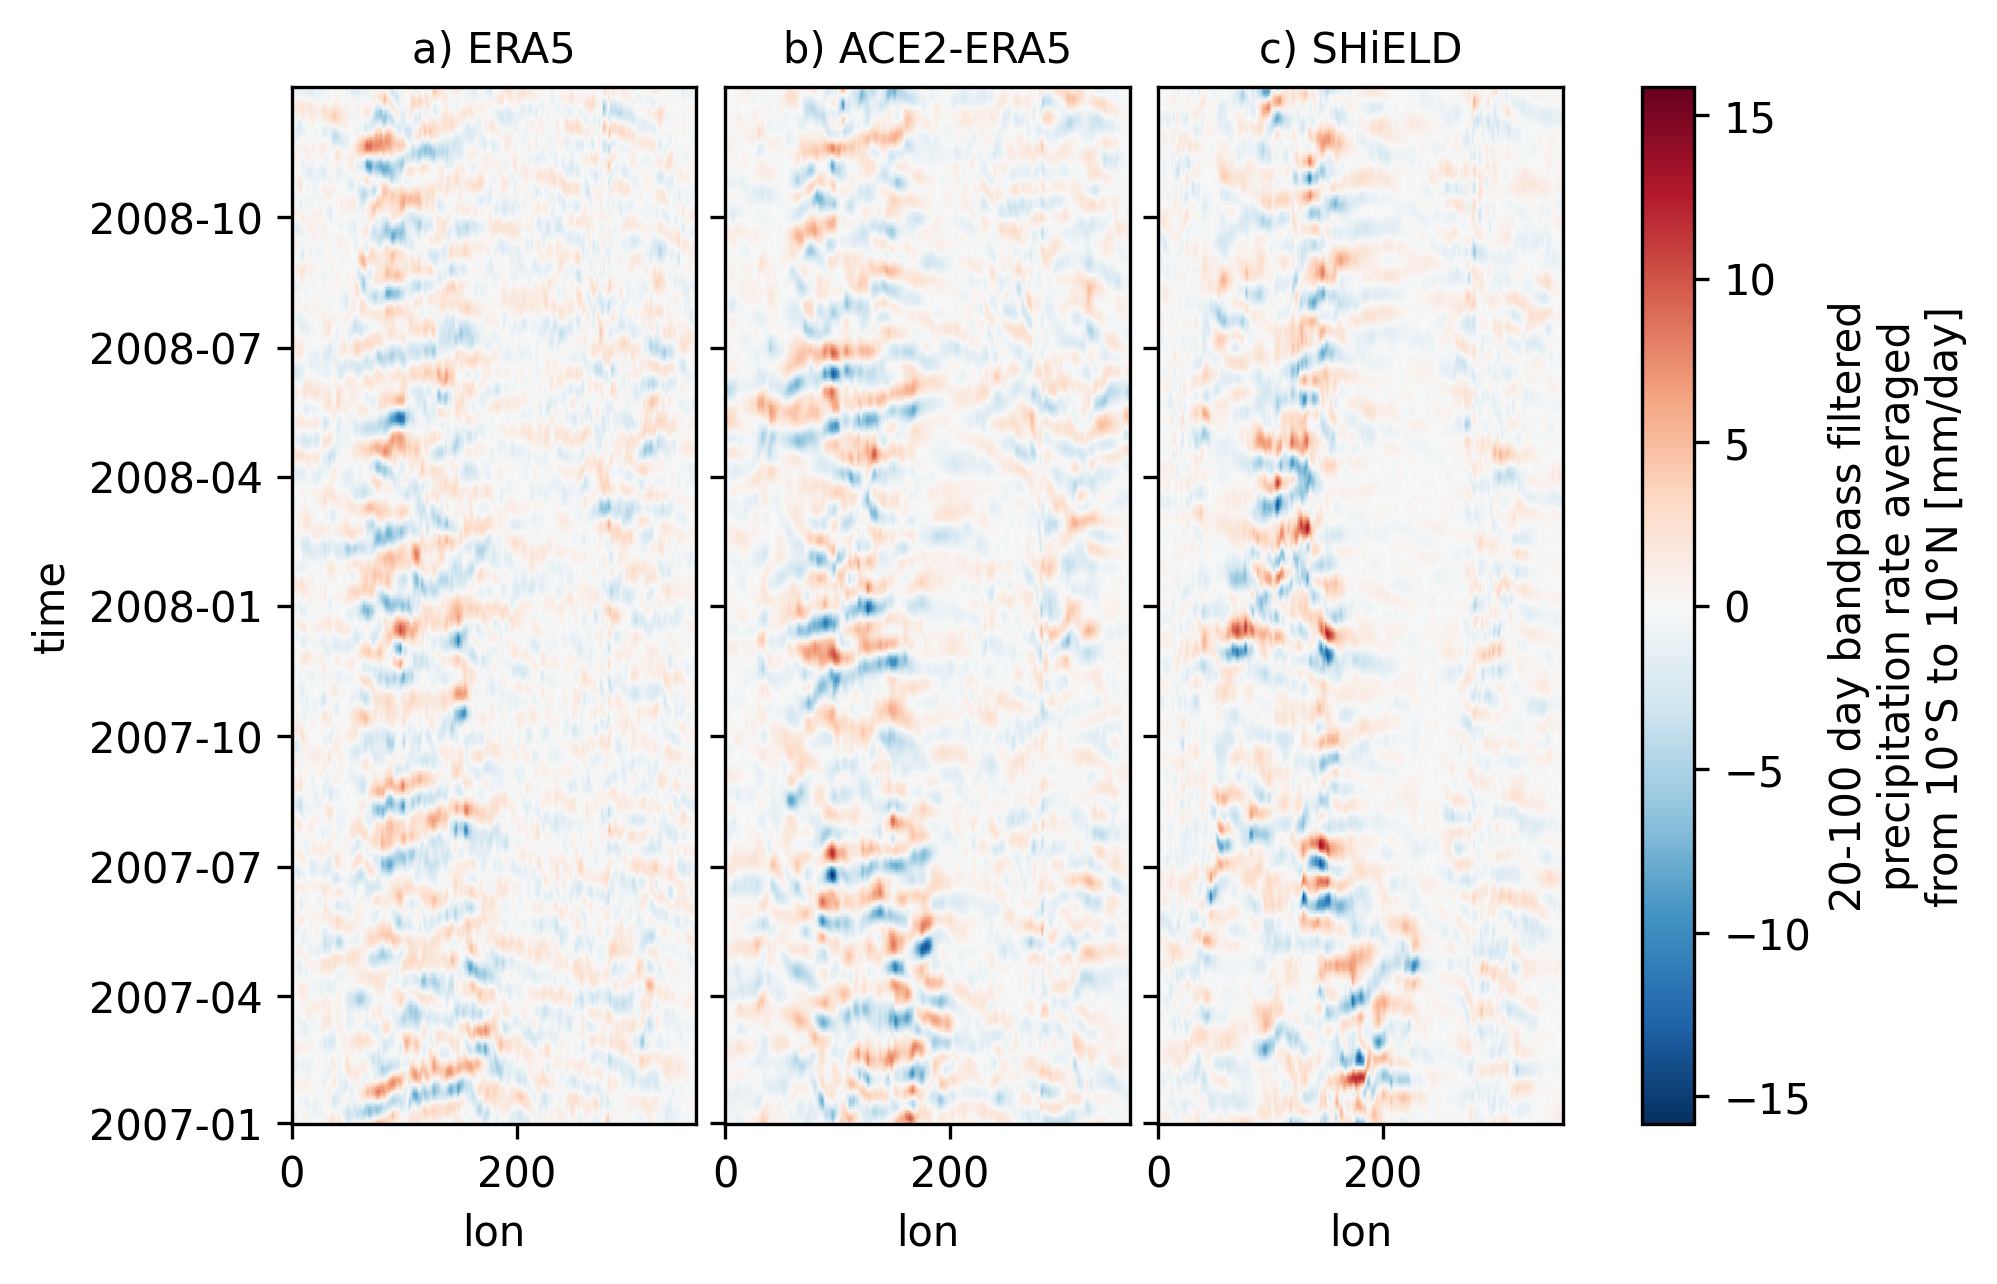

In [11]:
fg = filtered.sel(time=slice('2007', '2008')).plot(col='source')
fg.fig.set_size_inches((6, 5))
fg.set_titles(template='{value}')

In [12]:
def compute_lag_correlation(da, lon_slice, n_days=20):
    lag_correlations = []
    for day in range(-n_days, n_days + 1):
        x = da.sel(lon=lon_slice).mean('lon').shift(time=day)
        y = da
        lag_corr = xr.corr(x, y, dim='time')
        lag_correlations.append(lag_corr.assign_coords(lag=day))
    lag_correlations = xr.concat(lag_correlations, dim='lag')
    lag_correlations['lag'].attrs['units'] = 'days'
    lon_label = f'{lon_slice.start}°E-{lon_slice.stop}°E'
    lag_correlations.attrs['long_name'] = f'Lag correlation on precipitation at {lon_label}'
    return lag_correlations

### Compute and plot correlations with filtered data

In [13]:
lag_correlations = compute_lag_correlation(filtered, slice(80, 100), n_days=30)
lag_correlations.attrs['long_name'] = 'Lag correlation of 20-100 day tropical precipitation rate on 80°E-100°E precipitation'

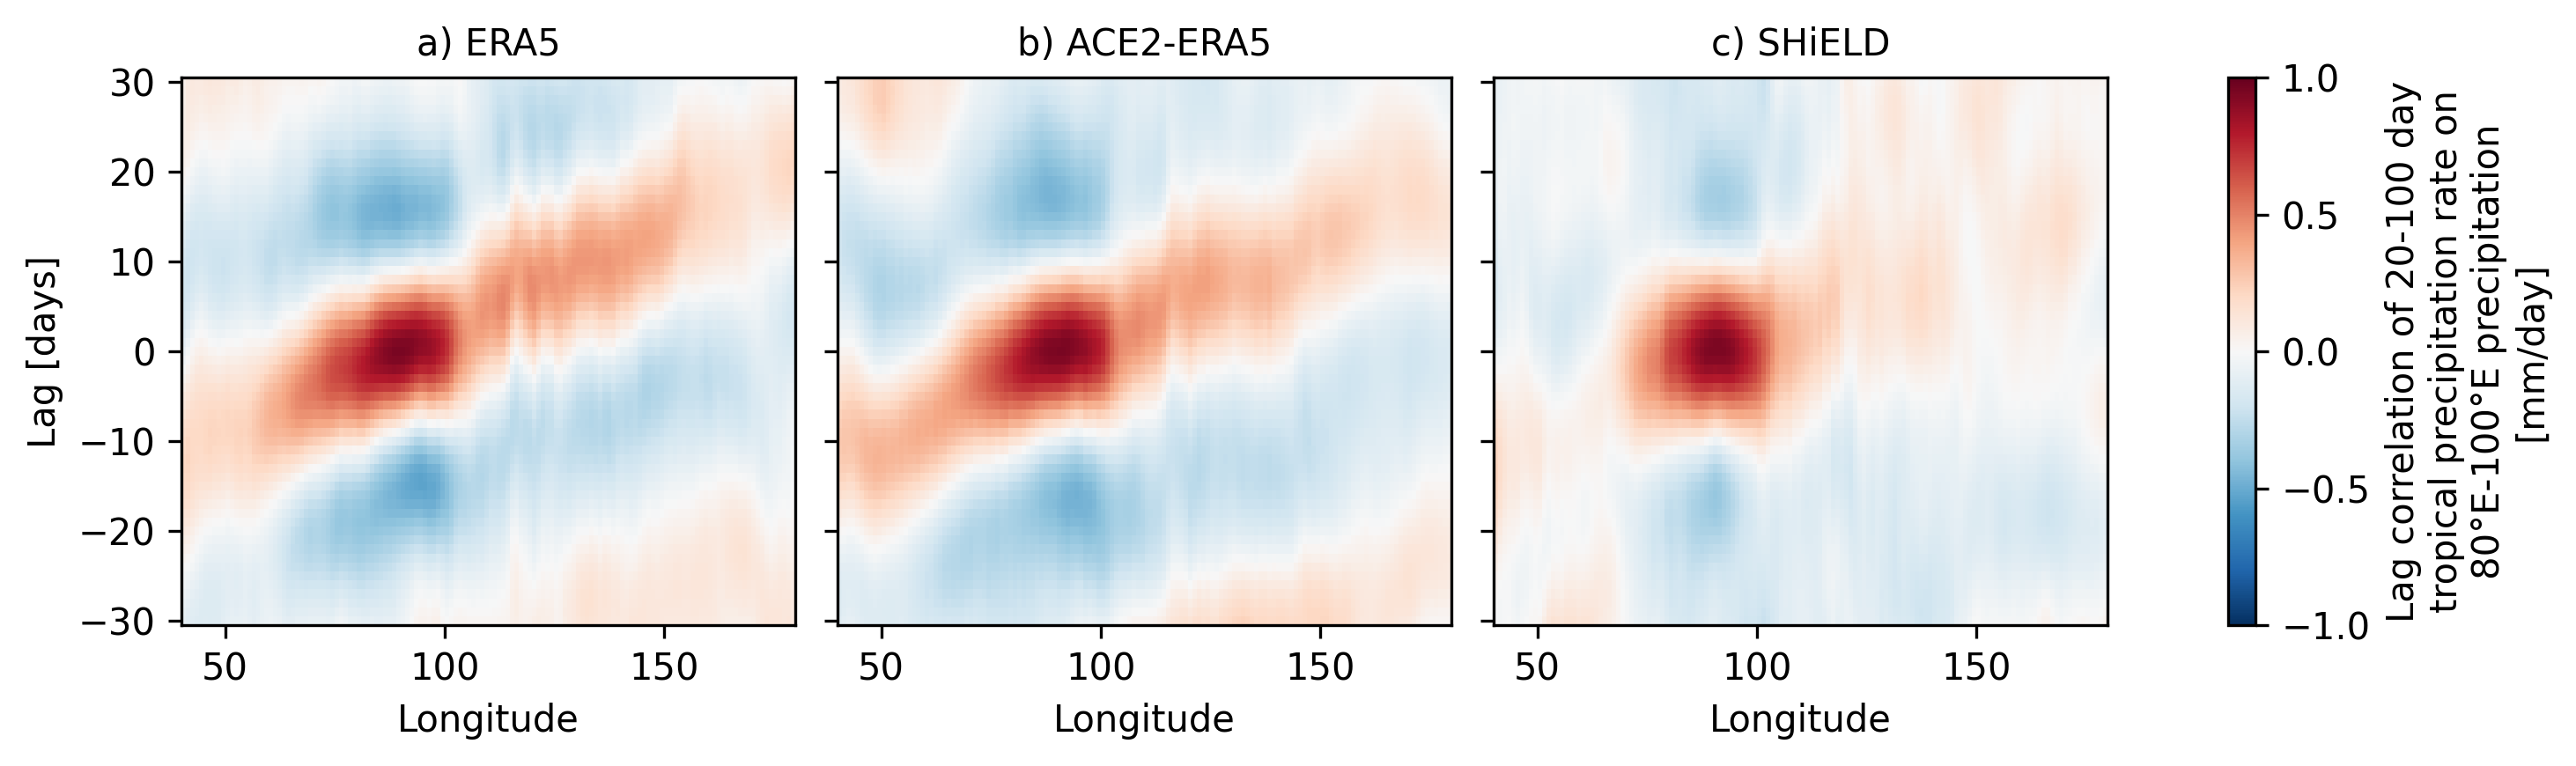

In [14]:
fg_lag = lag_correlations.plot(col='source', xlim=[40, 180], vmin=-1, vmax=1, cmap='RdBu_r')
fg_lag.set_ylabels('Lag [days]')
fg_lag.set_xlabels('Longitude')
for ax in fg.axs.flat:
    ax.set_xticks([40, 80, 120, 160], labels=['40°E', '80°E', '120°E', '160°E'])
fg_lag.set_titles(template='{value}')
fg_lag.fig.savefig('figures/era5_tropical_precip_lag_correlation.png', bbox_inches='tight', transparent=True, dpi=300)

### Plot combined figure